**CURSO**: *Machine Learning* en Geociencias<br />
**Profesor**: Edier Aristizábal (evaristizabalg@unal.edu.co) <br />
**Credits**: The content of this notebook is taken from [Qixiang Fang and Rens van de Schoot](https://www.rensvandeschoot.com/tutorials/generalised-linear-models-with-glm-and-lme4/). Other examples are found in [Nathan Onduma](https://rpubs.com/Onduma/mixedeffects), [ ECLS-K 2011](https://rstudio-pubs-static.s3.amazonaws.com/150280_e47af924d7a543d5acf140088ec7313e.html), [Love Börjeson](https://rpubs.com/loveb/mm).

In [ ]:
install.packages("ROCR")

# 15: Generalized Linear Models (GLMs)

In [2]:
library(lme4) # for multilevel models
library(tidyverse) # for data manipulation and plots
library(haven) #for reading sav data
library(sjstats) #for calculating intra-class correlation (ICC)
library(effects) #for plotting parameter effects
library(jtools) #for transformaing model summaries
library(ROCR) #for calculating area under the curve (AUC) statistics

Loading required package: Matrix

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: carData

lattice theme set by effectsTheme()
See ?effectsTheme for details.



In [3]:
ThaiEdu_Raw <- read_sav("https://github.com/MultiLevelAnalysis/Datasets-third-edition-Multilevel-book/blob/master/chapter%206/Thaieduc/thaieduc.sav?raw=true")
head(ThaiEdu_Raw)

SCHOOLID,SEX,PPED,REPEAT,MSESC
<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>
10101,0,1,0,NA
10101,0,1,0,NA
10101,0,1,0,NA
10101,0,1,0,NA
10101,0,1,0,NA
10101,0,1,0,NA


In [6]:
ThaiEdu_New <- ThaiEdu_Raw %>%
  mutate(SCHOOLID = factor(SCHOOLID),
         SEX = if_else(SEX == 0, "girl", "boy"),
         SEX = factor(SEX, levels = c("girl", "boy")),
         PPED = if_else(PPED == 0, "no", "yes"),
         PPED = factor(PPED, levels = c("no", "yes")))

head(ThaiEdu_New)

ERROR: Error in eval(expr, envir, enclos): object 'ThaiEdu_Raw' not found


In [12]:
ThaiEdu_New %>%
  summarise_each(list(~sum(is.na(.)))) %>%
  gather()

Warning message:
"`summarise_each()` was deprecated in dplyr 0.7.0.
ℹ Please use `across()` instead."


key,value
<chr>,<int>
SCHOOLID,0
SEX,0
PPED,0
REPEAT,0
MSESC,1066


In [13]:
ThaiEdu_New <- ThaiEdu_New %>%
  filter(!is.na(MSESC))

## Binary Logistic Regression

In [14]:
ThaiEdu_New %>%
  group_by(SEX) %>%
  summarise(REPEAT = sum(REPEAT))

SEX,REPEAT
<fct>,<dbl>
girl,428
boy,639


In [15]:
ThaiEdu_New %>%
  group_by(PPED) %>%
  summarise(REPEAT = sum(REPEAT))

PPED,REPEAT
<fct>,<dbl>
no,673
yes,394


It seems that the number of pupils who repeated a grade differs quite a bit between the two genders, with more male pupils having to repeat a grade. More pupils who did not have preschool education repeated a grade. This observation suggests that SEX and PPED might be predictive of REPEAT.

In [16]:
Model_Binary <- glm(formula = REPEAT ~ SEX + PPED,family = binomial(link = "logit"),data = ThaiEdu_New)
summary(Model_Binary)


Call:
glm(formula = REPEAT ~ SEX + PPED, family = binomial(link = "logit"), 
    data = ThaiEdu_New)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.76195    0.05798 -30.387  < 2e-16 ***
SEXboy       0.42983    0.06760   6.358 2.04e-10 ***
PPEDyes     -0.61298    0.06833  -8.971  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6140.8  on 7515  degrees of freedom
Residual deviance: 6016.2  on 7513  degrees of freedom
AIC: 6022.2

Number of Fisher Scoring iterations: 4


From the summary output above, we can see that SEX positively and significantly predicts a pupil’s probability of repeating a grade, while PPED negatively and significantly so. Specifically, in comparison to being a girl, being a boy is more likely to repeat a grade. Having previous schooling is less likely to result in repeating a grade.

To interpret the value of the parameter estimates, we need to exponentiate the estimates. The summ function from the jtools packages provides an easy to do so for any model fitted by glm. See below.

In [17]:
summ(Model_Binary, exp = T) # set "exp = T" to show exponentiated estimates; if you need standardised estimeets, set "scale = T"


MODEL INFO:
Observations: 7516
Dependent Variable: REPEAT
Type: Generalized linear model
  Family: binomial 
  Link function: logit 

MODEL FIT:
χ²(2) = 124.55, p = 0.00
Pseudo-R² (Cragg-Uhler) = 0.03
Pseudo-R² (McFadden) = 0.02
AIC = 6022.21, BIC = 6042.98 

Standard errors: MLE
------------------------------------------------------------
                    exp(Est.)   2.5%   97.5%   z val.      p
----------------- ----------- ------ ------- -------- ------
(Intercept)              0.17   0.15    0.19   -30.39   0.00
SEXboy                   1.54   1.35    1.75     6.36   0.00
PPEDyes                  0.54   0.47    0.62    -8.97   0.00
------------------------------------------------------------

Note that the interpretation of the parameter estimates is linked to the odds rather than probabilities. The definition of odds is: P(event occurring)/P(event not occurring). In this analysis, assuming everything else stays the same, being a boy increases the odds of repeating a grade by 54%, in comparison to being a girl; having preschool education lowers the odds of repeating a grade by (1 – 0.54)% = 46%, in comparison to not having preschool education, assuming everything else stays constant.

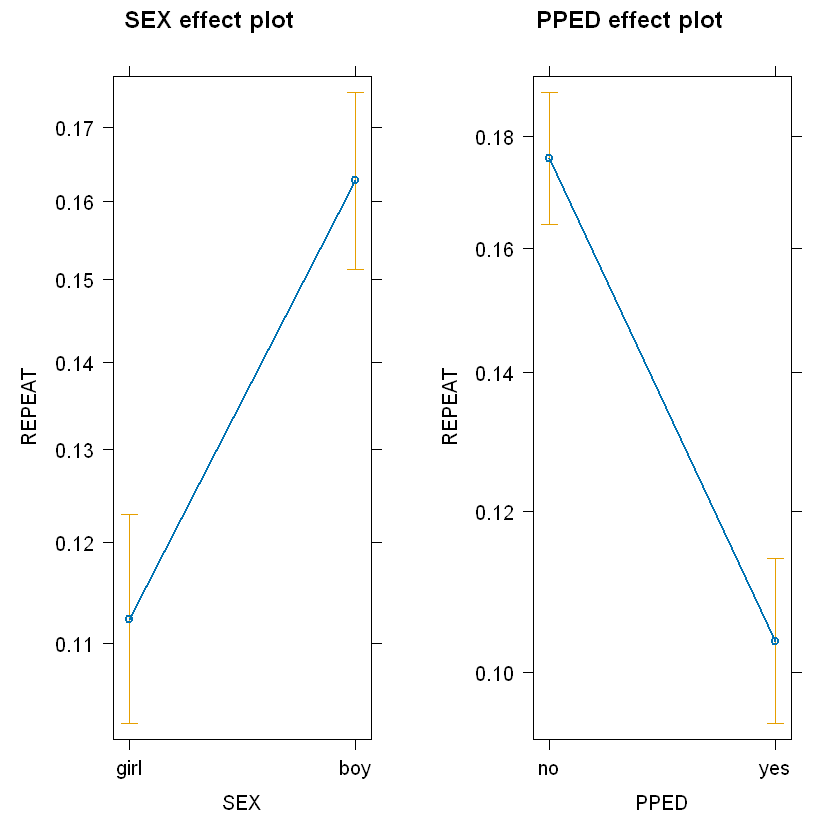

In [18]:
plot(allEffects(Model_Binary))

Note that in both plots, the y scale refers to the probability of repeating a grade rather than the odds. Probabilities are more interpretable than odds. The probability scores for each variable are calculated by assuming that the other variables in the model are constant and take on their average values. As we can see, assuming that a pupil has an average preschool education, being a boy has a higher probability (0.16) of repeating a grade than being a girl 0.11). Likewise, assuming that a pupil has an average gender, having preschool education has a lower probability (0.11) of repeating a grade than not having preschool education (0.18). Note that in both plots the confidence intervals for the estimates are also included to give us some idea of the uncertainties of the estimates.

Note that the notion of average preschool education and gender may sound strange, given they are categorical variables (i.e. factors). If you are not comfortable with the idea of assuming an average factor, you can specify your intended factor level as the reference point, by using the fixed.predictors = list(given.values = ...) argument in the allEffects function. See below:

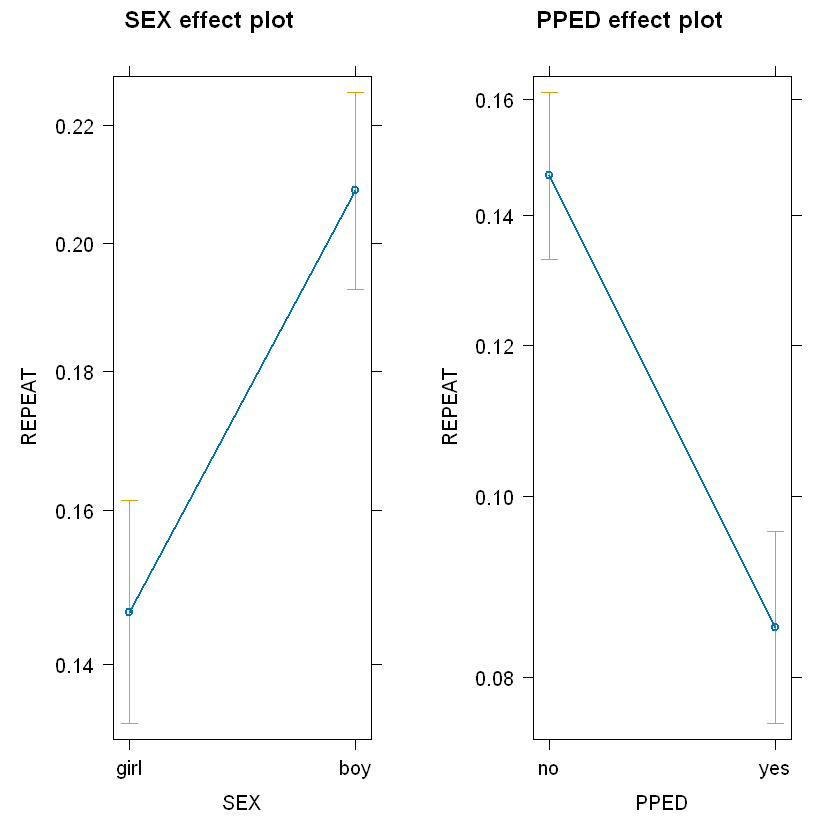

In [19]:
plot(allEffects(Model_Binary, fixed.predictors = list(given.values=c(SEXboy=0, PPEDyes = 0))))


Setting SEXboy = 0 means that for the PPED effect plot, the reference level of the SEX variable is set to 0; PPEDyes = 0 results in the 0 being the reference level of the PPED variable in the SEX effect plot.

Therefore, as the two plots above show, assuming that a pupil has no preschool education, being a boy has a higher probability (~0.20) of repeating a grade than being a girl ~0.14); assuming that a pupil is female, having preschool education has a lower probability (~0.09) of repeating a grade than not having preschool education (~0.15).

A logistic regression model has a better fit to the data if the model, compared with a model with fewer predictors, demonstrates an improvement in the fit. This is performed using the likelihood ratio test, which compares the likelihood of the data under the full model against the likelihood of the data under a model with fewer predictors. Removing predictor variables from a model will almost always make the model fit less well (i.e. a model will have a lower log likelihood), but it is useful to test whether the observed difference in model fit is statistically significant.

In [20]:
#specify a model with only the `SEX` variable
Model_Binary_Test <- glm(formula = REPEAT ~ SEX,family = binomial(link = "logit"),data = ThaiEdu_New)

#use the `anova()` function to run the likelihood ratio test
anova(Model_Binary_Test, Model_Binary, test ="Chisq")

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,7514,6099.148,NA,NA,NA
2,7513,6016.207,1,82.94112,8.453409e-20


As we can see, the model with both SEX and PPED predictors provide a significantly better fit to the data than does the model with only the SEX variable. Note that this method can also be used to determine whether it is necessary to include one or a group of variables.

The Akaike information criterion (AIC) is another measure for model selection. Different from the likelihood ratio test, the calculation of AIC not only regards the goodness of fit of a model, but also takes into account the simplicity of the model. In this way, AIC deals with the trade-off between goodness of fit and complexity of the model, and as a result, disencourages overfitting. A smaller AIC is preferred.

In [21]:
Model_Binary_Test$aic

[1] 6103.148

In [22]:
Model_Binary$aic

[1] 6022.207

With a smaller AIC value, the model with both SEX and PPED predictors is preferred to the one with just the SEX predictor.

The percentage of correct classification is another useful measure to see how well the model fits the data.

In [23]:
#use the `predict()` function to calculate the predicted probabilities of pupils in the original data from the fitted model
Pred <- predict(Model_Binary, type = "response")
Pred <- if_else(Pred > 0.5, 1, 0)
ConfusionMatrix <- table(Pred, pull(ThaiEdu_New, REPEAT)) #`pull` results in a vector
#correct classification rate
sum(diag(ConfusionMatrix))/sum(ConfusionMatrix)

[1] 0.8580362

In [24]:
ConfusionMatrix

    
Pred    0    1
   0 6449 1067

We can see that the model correctly classifies 85.8% of all the observations. However, a closer look reveals that the model predicts all of the observations to belong to class “0”, meaning that all pupils are predicted not to repeat a grade. Given that the majority category of the REPEAT variable is 0 (No), the model does not perform better in classification than simply assigning all observations to the majority class 0 (No).

An alternative to using correct classification rate is the Area under the Curve (AUC) measure. The AUC measures discrimination, that is, the ability of the test to correctly classify those with and without the target response. In the current data, the target response is repeating a grade. We randomly pick one pupil from the “repeating a grade” group and one from the “not repeating a grade” group. The pupil with the higher predicted probability should be the one from the “repeating a grade” group. The AUC is the percentage of randomly drawn pairs for which this is true. This procedure sets AUC apart from the correct classification rate because the AUC is not dependent on the imblance of the proportions of classes in the outcome variable. A value of 0.50 means that the model does not classify better than chance. A good model should have an AUC score much higher than 0.50 (preferably higher than 0.80).

In [25]:
# Compute AUC for predicting Class with the model
Prob <- predict(Model_Binary, type="response")
Pred <- prediction(Prob, as.vector(pull(ThaiEdu_New, REPEAT)))
AUC <- performance(Pred, measure = "auc")
AUC <- AUC@y.values[[1]]
AUC

[1] 0.6013622

With an AUC score of 0.60, the model does not discriminate well.

## Binomial Logistic Regression

As mentioned in the beginning, logistic regression can also be used to model count or proportion data. Binary logistic regression assumes that the outcome variable comes from a bernoulli distribution (which is a special case of binomial distributions) where the number of trial n
 is 1 and thus the outcome variable can only be 1 or 0. In contrast, binomial logistic regression assumes that the number of the target events follows a binomial distribution with n
 trials and probability q
. In this way, binomial logistic regression allows the outcome variable to take any non-negative integer value and thus is capable of handling count data.

The Thai Educational Data records information about individual pupils that are clustered within schools. By aggregating the number of pupils who repeated a grade by school, we obtain a new data set where each row represents a school, with information about the proportion of pupils repeating a grade in that school. The MSESC (mean SES score) is also on the school level; therefore, it can be used to predict proportion or count of pupils who repeat a grade in a particular school. See below.

In [26]:
ThaiEdu_Prop <- ThaiEdu_New %>%
  group_by(SCHOOLID, MSESC) %>%
  summarise(REPEAT = sum(REPEAT),
            TOTAL = n()) %>%
  ungroup()

head(ThaiEdu_Prop)

`summarise()` has grouped output by 'SCHOOLID'. You can override using the `.groups` argument.


SCHOOLID,MSESC,REPEAT,TOTAL
<fct>,<dbl>,<dbl>,<int>
10103,0.88,1,17
10104,0.20,0,29
10105,-0.07,5,18
10106,0.47,0,5
10108,0.76,3,19
10109,1.06,9,21


In this new data set, REPEAT refers to the number of pupils who repeated a grade; TOTAL refers to the total number of students in a particular school.

`geom_smooth()` using formula = 'y ~ x'


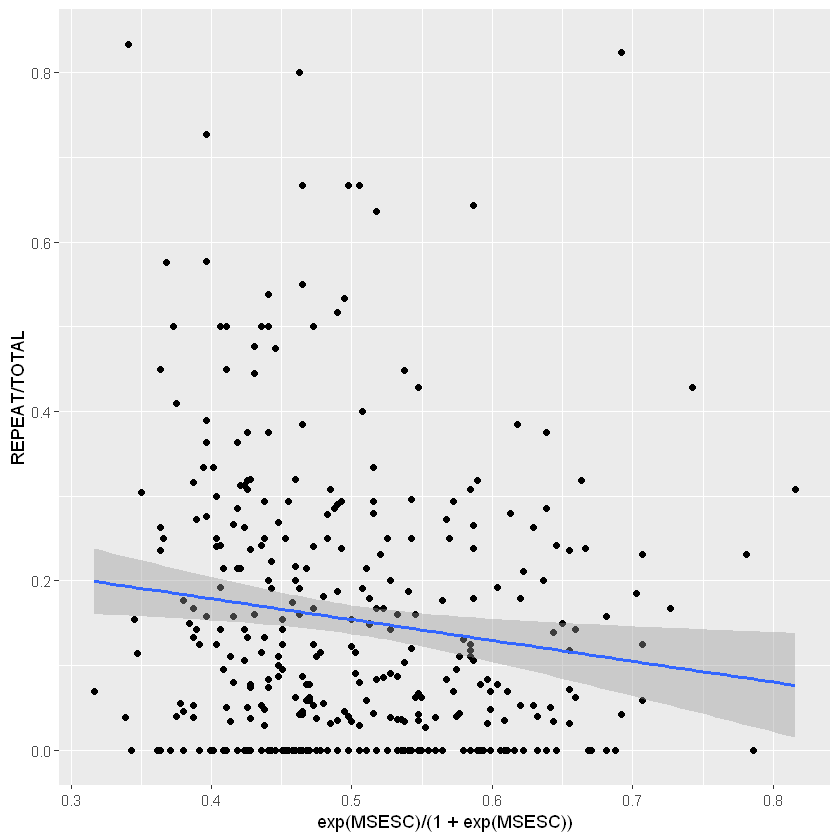

In [27]:
ThaiEdu_Prop %>%
  ggplot(aes(x = exp(MSESC)/(1+exp(MSESC)), y = REPEAT/TOTAL)) +
  geom_point() +
  geom_smooth(method = "lm")

We can see that the proportion of students who repeated a grade is negatively related to the inverse-logit of MSESC. Note that we model the variable MSESC as its inverse-logit because in a binomial regression model, we assume a linear relationship between the inverse-logit of the linear predictor and the outcome (i.e. proportion of events), not linearity between the predictor itself and the outcome.

In [5]:
colnames(ThaiEdu_Prop)

ERROR: Error in eval(expr, envir, enclos): object 'ThaiEdu_Prop' not found


In [28]:
Model_Prop <- glm(formula = cbind(REPEAT, TOTAL-REPEAT) ~ MSESC,family = binomial(logit), data = ThaiEdu_Prop)
summary(Model_Prop)


Call:
glm(formula = cbind(REPEAT, TOTAL - REPEAT) ~ MSESC, family = binomial(logit), 
    data = ThaiEdu_Prop)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.80434    0.03324 -54.280  < 2e-16 ***
MSESC       -0.43644    0.09164  -4.763 1.91e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1480.7  on 355  degrees of freedom
Residual deviance: 1457.3  on 354  degrees of freedom
AIC: 2192

Number of Fisher Scoring iterations: 5


The parameter interpretation in a binomial regression model is the same as that in a binary logistic regression model. We know from the model summary above that the mean SES score of a school is negatively related to the odds of students repeating a grade in that school. To enhance interpretability, we use the summ() function again to calculate the exponentiated coefficient estimate of MSESC. Since MSESC is a continous variable, we can standardise the exponentiated MSESC estimate (by multiplying the original estimate with the SD of the variable, and then then exponentiating the resulting number).

In [29]:
#Note that to use the summ() function for a binomial regression model, we need to make the outcome variable explicit objects:
REPEAT <- pull(filter(ThaiEdu_Prop, !is.na(MSESC)), REPEAT)
TOTAL <- pull(filter(ThaiEdu_Prop, !is.na(MSESC)), TOTAL)
summ(Model_Prop, exp = T, scale = T)

MODEL INFO:
Observations: 356
Dependent Variable: cbind(REPEAT, TOTAL - REPEAT)
Type: Generalized linear model
  Family: binomial 
  Link function: logit 

MODEL FIT:
χ²(1) = 23.36, p = 0.00
Pseudo-R² (Cragg-Uhler) = 0.06
Pseudo-R² (McFadden) = 0.01
AIC = 2191.96, BIC = 2199.71 

Standard errors: MLE
------------------------------------------------------------
                    exp(Est.)   2.5%   97.5%   z val.      p
----------------- ----------- ------ ------- -------- ------
(Intercept)              0.16   0.15    0.18   -54.26   0.00
MSESC                    0.85   0.79    0.91    -4.76   0.00
------------------------------------------------------------

Continuous predictors are mean-centered and scaled by 1 s.d. The outcome variable remains in its original units.

We can see that with a SD increase in MSESC, the odds of students repeating a grade is lowered by 1 – 85% = 15%.

We can visualise the effect of MSESC.

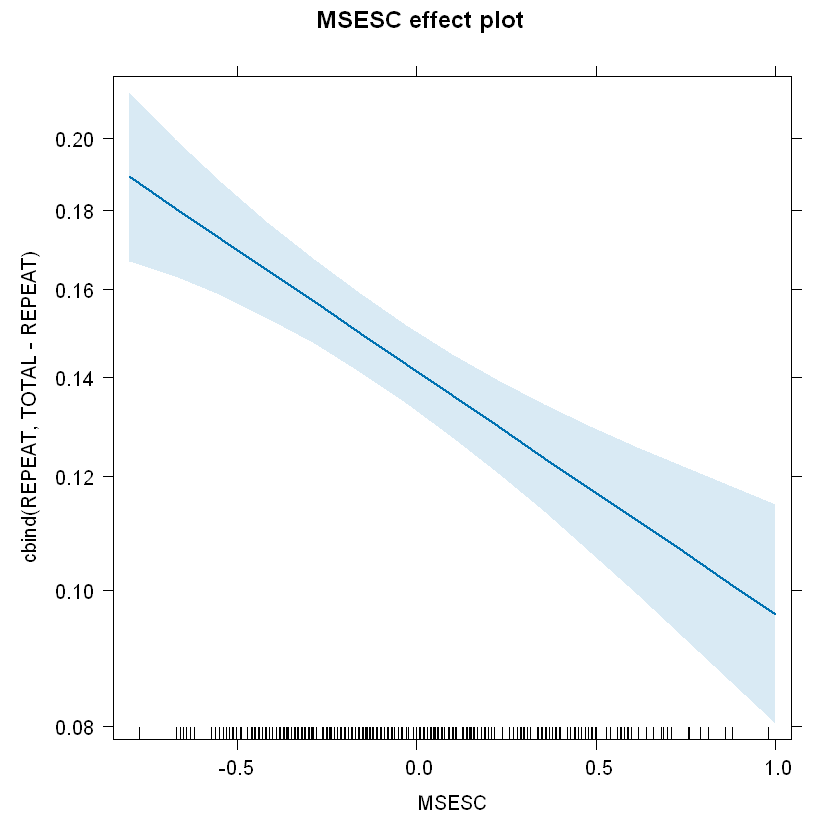

In [30]:
plot(allEffects(Model_Prop))

The plot above shows the expected influence of MSESC on the probability of a pupil repeating a grade. Holding everything else constant, as MSESC increases, the probability of a pupil repeating a grade lowers (from 0.19 to 0.10). The blue shaded areas indicate the 95% confidence intervals of the predicted values at each value of MSESC.

## Multilevel Binary Logistic Regression

The binary logistic regression model introduced earlier is limited to modelling the effects of pupil-level predictors; the binomial logistic regression is limited to modelling the effects of school-level predictors. To incorporate both pupil-level and school-level predictors, we can use multilevel models, specifically, multilevel binary logistic regression. If you are unfamiliar with multilevel models, you can use Multilevel analysis: Techniques and applications for reference and this tutorial for a good introduction to multilevel models with the lme4 package in R.

In addition to the motivation above, there are more reasons to use multilevel models. For instance, as the data are clustered within schools, it is likely that pupils from the same school are more similar to each other than those from other schools. Because of this, in one school, the probability of a pupil repeating a grade may be high, while in another school, low. Furthermore, even the relationship between the outcome (i.e. repeating a grade) and the predictor variabales (e.g. gender, preschool education, SES) may be different across schools. Also note that there are missing values in the MSESC variable. Using multilevel models can appropriately address these issues.

See the following plot as an example. The plot shows the proportions of students repeating a grade across schools. We can see vast differences across schools. Therefore, we may need multilevel models.

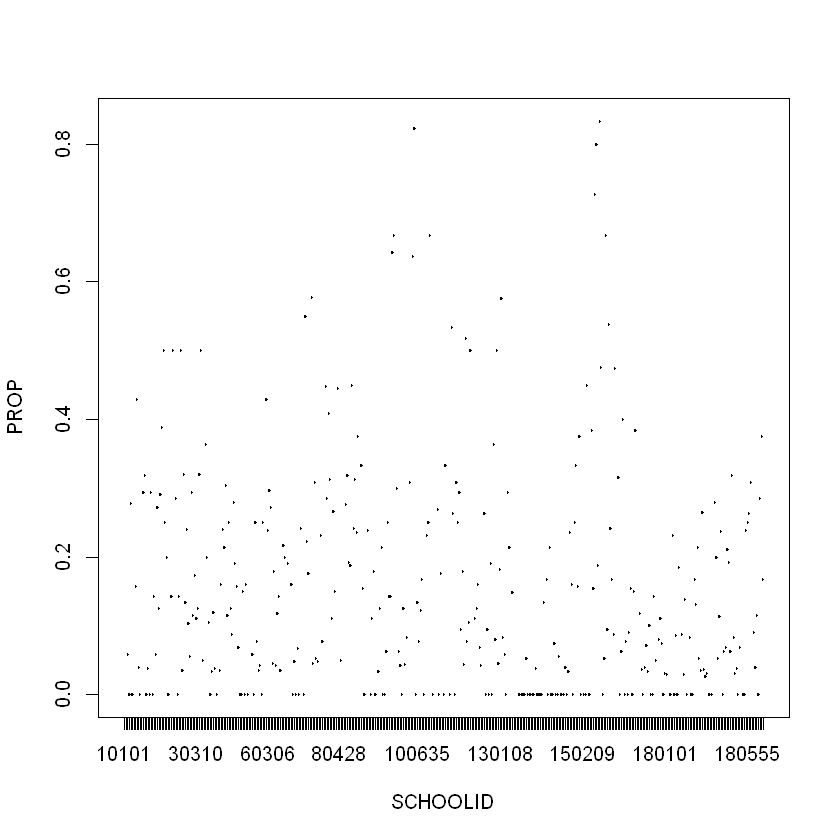

In [31]:
ThaiEdu_New %>%
  group_by(SCHOOLID) %>%
  summarise(PROP = sum(REPEAT)/n()) %>%
  plot()

We can also plot the relationship between SEX and REPEAT by SCHOOLID, to see whether the relationship between gender and repeating a grade differs by school.

`geom_smooth()` using formula = 'y ~ x'


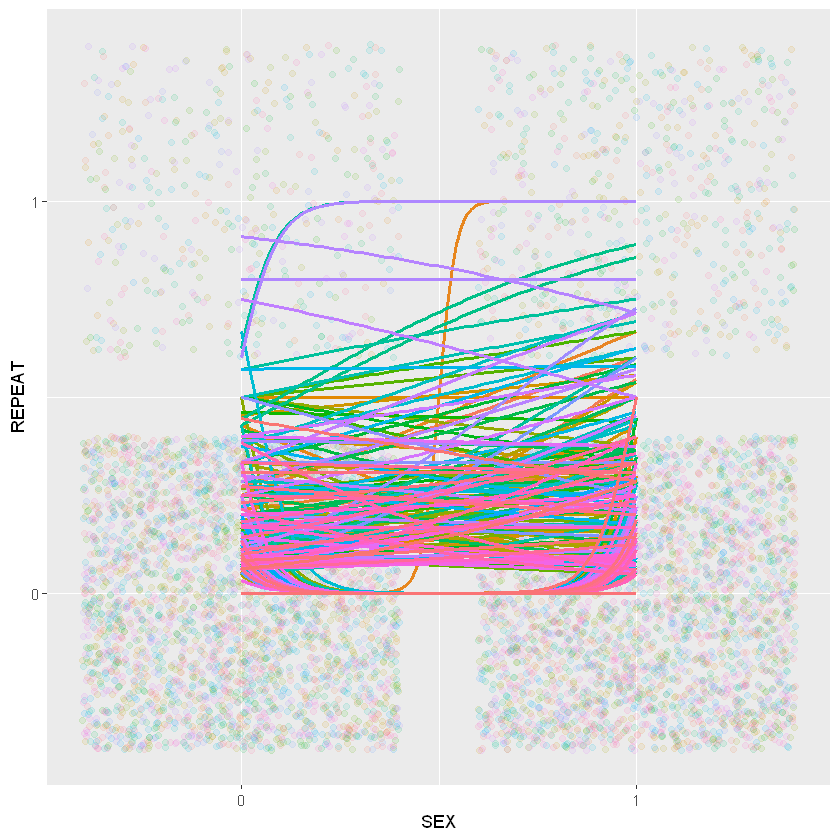

In [32]:
ThaiEdu_New %>%
  mutate(SEX = if_else(SEX == "boy", 1, 0)) %>%
  ggplot(aes(x = SEX, y = REPEAT, color = as.factor(SCHOOLID))) +
  geom_point(alpha = .1, position = "jitter")+
  geom_smooth(method = "glm", se = F, 
              method.args = list(family = "binomial")) +
  theme(legend.position = "none") +
  scale_x_continuous(breaks = c(0, 1)) +
  scale_y_continuous(breaks = c(0, 1))

In the plot above, different colors represent different schools. We can see that the relationship between SEX and REPEAT appears to be quite different across schools.

We can make the same plot for PPED and REPEAT.

`geom_smooth()` using formula = 'y ~ x'


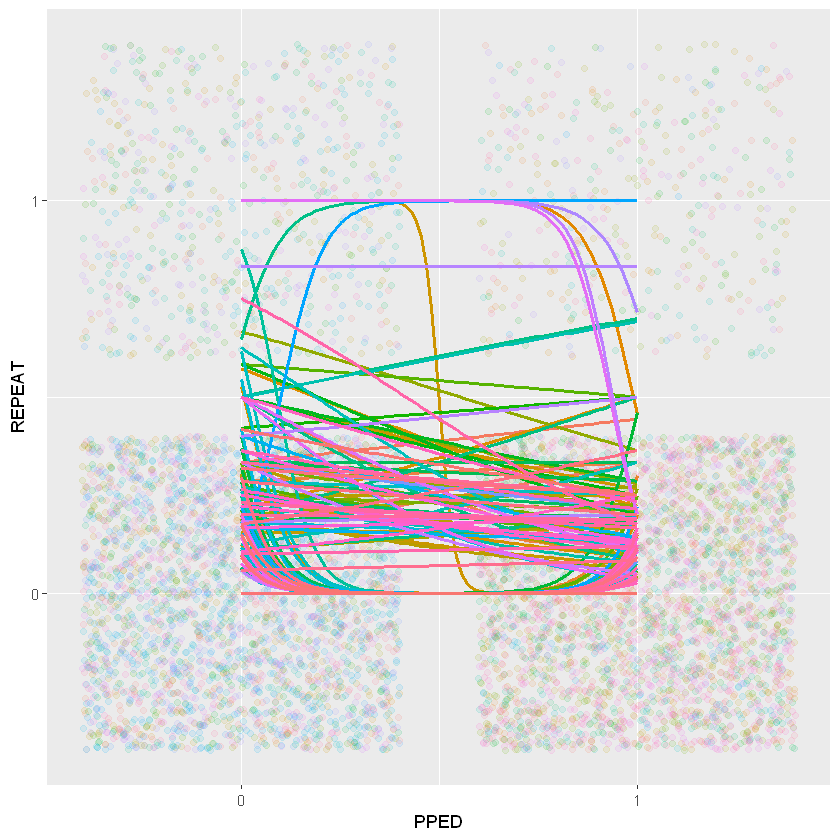

In [33]:
ThaiEdu_New %>%
  mutate(PPED = if_else(PPED == "yes", 1, 0)) %>%
  ggplot(aes(x = PPED, y = REPEAT, color = as.factor(SCHOOLID))) +
  geom_point(alpha = .1, position = "jitter")+
  geom_smooth(method = "glm", se = F, 
              method.args = list(family = "binomial")) +
  theme(legend.position = "none") +
  scale_x_continuous(breaks = c(0, 1)) +
  scale_y_continuous(breaks = c(0, 1))

The relationship between PPED and REPEAT also appears to be quite different across schools. However, we can also see that most of the relationships follow a downward trend, going from 0 (no previous schooling) to 1 (with previous schooling), indicating a negative relationship between PPED and REPEAT.

Because of the observations above, we can conclude that there is a need for multilevel modelling in the current data, with not only a random intercept (SCHOOLID) but potentially also random slopes of the SEX and PPED.

Prior to fitting a multilevel model, it is necessary to center the predictors by using an appropriately chosen centering method (i.e. grand-mean centering or within-cluster centering), because the centering approach matters for the interpretation of the model estimates. Following the advice of Enders and Tofighi (2007), we should use within-cluster centering for the first-level predictors SEX and PPED, and grand-mean centering for the second-level predictor MSESC.

In [34]:
ThaiEdu_Center <- ThaiEdu_New %>%
  mutate(SEX = if_else(SEX == "girl", 0, 1),
         PPED = if_else(PPED == "yes", 1, 0)) %>%
  group_by(SCHOOLID) %>%
  mutate(SEX = SEX - mean(SEX),
         PPED = PPED - mean(PPED)) %>%
  ungroup() %>%
  mutate(MSESC = MSESC - mean(MSESC, na.rm = T))

head(ThaiEdu_Center)

SCHOOLID,SEX,PPED,REPEAT,MSESC
<fct>,<dbl>,<dbl>,<dbl+lbl>,<dbl>
10103,-0.6470588,-0.8823529,0,0.870326
10103,-0.6470588,-0.8823529,0,0.870326
10103,-0.6470588,0.1176471,0,0.870326
10103,-0.6470588,0.1176471,0,0.870326
10103,-0.6470588,0.1176471,0,0.870326
10103,-0.6470588,0.1176471,0,0.870326


### Intercept Only Model

To specify a multilevel model, we use the glmer function from the lme4 package. Note that the random effect term should be included in parentheses. In addition, within the parentheses, the random slope term(s) and the cluster terms should be separated by |. Note that we use an additional argument control = glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun=2e5)) in the glmer function to specify a higher number of maximum iterations than default (10000). This might be necessary because a multilevel model may require a large number of iterations to converge.

We start by specifying an intercept-only model, in order to assess the impact of the clustering structure of the data.

In [36]:
Model_Multi_Intercept <- glmer(formula = REPEAT ~ 1 + (1|SCHOOLID),
                               family = "binomial",
                               data = ThaiEdu_Center,
                               control = glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun=2e5)))

summary(Model_Multi_Intercept)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: REPEAT ~ 1 + (1 | SCHOOLID)
   Data: ThaiEdu_Center
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  5547.1   5560.9  -2771.5   5543.1     7514 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6254 -0.4174 -0.2487 -0.1765  4.7824 

Random effects:
 Groups   Name        Variance Std.Dev.
 SCHOOLID (Intercept) 1.646    1.283   
Number of obs: 7516, groups:  SCHOOLID, 356

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.2248     0.0839  -26.52   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Below we calculate the ICC (intra-class correlation) of the intercept-only model.

In [37]:
performance::icc(Model_Multi_Intercept)

ERROR: Error: 'icc' is defunct.
Use 'performance::icc()' instead.
See help("Defunct")


An ICC of 0.33 means that 33% of the variation in the outcome variable can be accounted for by the clustering stucture of the data. This provides evidence that a multilevel model may make a difference to the model estimates, in comparison with a non-multilevel model. Therefore, the use of multilevel models is necessary and warrantied.

It is good practice to build a multilevel model step by step. However, as this tutorial’s focus is not on muitilevel modelling, we go directly from the intercept-only model to the full-model that we are ultimately interested in. In the full model, we include not only fixed effect terms of SEX, PPED and MSESC and a random intercept term, but also random slope terms for SEX and PPED. Note that we specify family = binomial(link = "logit"), as this model is essentially a binary logistic regression model.

In [41]:
Model_Multi_Full <- glmer(REPEAT ~ SEX + PPED + MSESC + (1 + SEX + PPED|SCHOOLID),
                          family = "binomial",
                          data = ThaiEdu_Center,
                          control = glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun=2e5)))

summary(Model_Multi_Full)

boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: REPEAT ~ SEX + PPED + MSESC + (1 + SEX + PPED | SCHOOLID)
   Data: ThaiEdu_Center
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

     AIC      BIC   logLik deviance df.resid 
  5468.0   5537.2  -2724.0   5448.0     7506 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4508 -0.4003 -0.2451 -0.1732  5.6938 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 SCHOOLID (Intercept) 1.66585  1.2907              
          SEX         0.15439  0.3929    0.56      
          PPED        0.04747  0.2179   -0.61  0.32
Number of obs: 7516, groups:  SCHOOLID, 356

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.2727     0.0886 -25.652  < 2e-16 ***
SEX           0.4093     0.1105   3.704 0.000213 ***
PPED         -0.5555     0.1534  -3.621 0.000293 ***
MSESC        -0.50

The results (pertaining to the fixed effects) are similar to the results of the previous binary logistic regression and binomial logistic regression models. On the pupil-level, SEX has a significant and positive influence on the odds of a pupil repeating a grade, while PPED has a significant and negative influence. On the school-level, MSESC has a significant and negative effect on the outcome variable. Let’s also look at the variance of the random effect terms.

Again, we can use the summ() function to retrieve the exponentiated coefficient estimates for easier interpretation.

In [ ]:
summ(Model_Multi_Full, exp = T)

We can also use the allEffects function to visualise the effects of the parameter estimates. Note that because the first-level categorical variables (SEX and PPED) are centered, they are treated as continuous variables in the model and as well in the following effect plots.

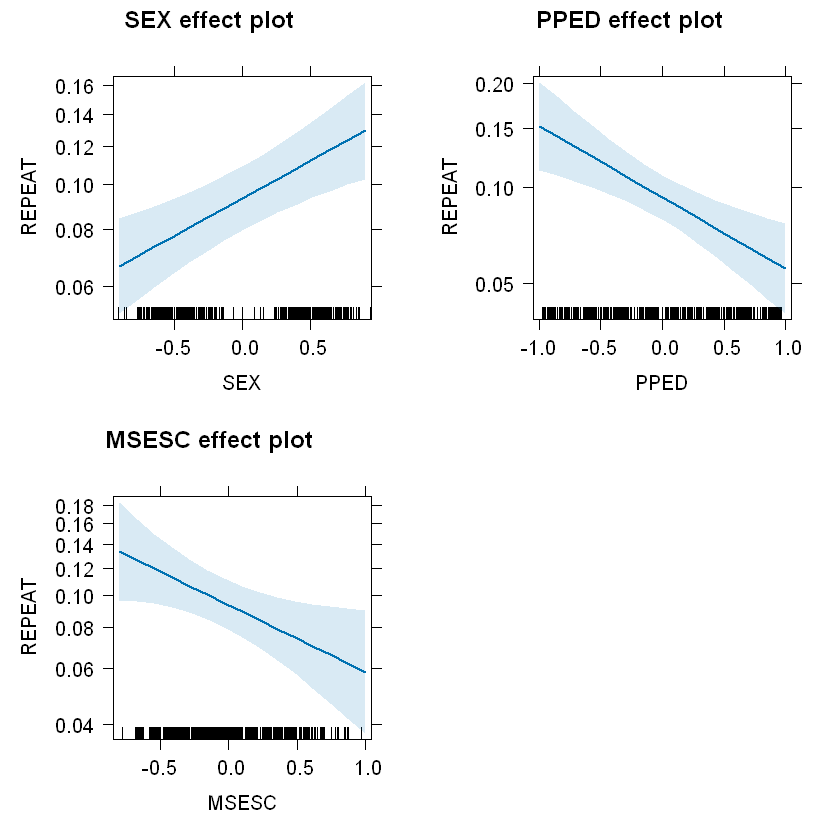

In [42]:
plot(allEffects(Model_Multi_Full))

In addition to the fixed-effect terms, let’s also look at the random effect terms. From the ICC value before, we know that it’s necessary to include a random intercept. However, the necessity of including random slopes for SEX and PPED is less clear. To find this out, we can use the likelihood ratio test and AIC to judge whether the inclusion of the random slope(s) improves model fit.

In [44]:
#let's fit a less-than-full model that leaves out the random slope term of `SEX`
Model_Multi_Full_No_SEX <- glmer(REPEAT ~ SEX + PPED + MSESC + (1 + PPED|SCHOOLID),
                                 family = "binomial",
                                 data = ThaiEdu_Center,
                                 control = glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun=2e5)))

boundary (singular) fit: see help('isSingular')



In [45]:
#let's fit a less-than-full model that leaves out the random slope term of `PPED`
Model_Multi_Full_No_PPED <- glmer(REPEAT ~ SEX + PPED + MSESC + (1 + SEX|SCHOOLID),
                                  family = "binomial",
                                  data = ThaiEdu_Center,
                                  control = glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun=2e5)))

#let's fit a less-than-full model that leaves out the random slope terms of both `SEX` and `PPED`
Model_Multi_Full_No_Random_Slope <- glmer(REPEAT ~ SEX + PPED + MSESC + (1|SCHOOLID),
                                      family = "binomial",
                                      data = ThaiEdu_Center,
                                      control = glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun=2e5)))

In [46]:
#compare the full model with that model that excludes `SEX`
anova(Model_Multi_Full_No_SEX, Model_Multi_Full, test="Chisq")

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model_Multi_Full_No_SEX,7,5466.591,5515.064,-2726.295,5452.591,NA,NA,NA
Model_Multi_Full,10,5467.985,5537.233,-2723.993,5447.985,4.605436,3,0.2030763


In [47]:
#compare the full model with that model that excludes `PPED`
anova(Model_Multi_Full_No_PPED, Model_Multi_Full, test="Chisq")

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model_Multi_Full_No_PPED,7,5462.890,5511.364,-2724.445,5448.890,NA,NA,NA
Model_Multi_Full,10,5467.985,5537.233,-2723.993,5447.985,0.9052208,3,0.8241677


In [48]:
anova(Model_Multi_Full_No_Random_Slope, Model_Multi_Full, test="Chisq")

,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model_Multi_Full_No_Random_Slope,5,5463.210,5497.834,-2726.605,5453.210,NA,NA,NA
Model_Multi_Full,10,5467.985,5537.233,-2723.993,5447.985,5.224897,5,0.3890547


From the all insignificant likelihood ratio test results (Pr(>Chisq) > 0.05), we can conclude that there is no significant improvement in model fit by adding any random slope terms.

AIC:

In [49]:
AIC(logLik(Model_Multi_Full)) #full model

[1] 5467.985

In [50]:
AIC(logLik(Model_Multi_Full_No_SEX)) #model without SEX

[1] 5466.591

In [51]:
AIC(logLik(Model_Multi_Full_No_PPED)) #model without PPED

[1] 5462.89

In [52]:
AIC(logLik(Model_Multi_Full_No_Random_Slope)) #model without random slopes

[1] 5463.21